In [715]:
import sys
from itertools import product
from os import listdir
import numpy as np
import scipy.sparse as sparse
import json
from collections import defaultdict

In [716]:
def poisson_regression(X, y, init=None):
    print('Estimating...', X.shape, y.shape)
    
    # cvxpy
    n = cp.Variable(X.shape[1])
    if init is not None:
        n.value = init

    mu = np.sum(X, axis=0)
    objective = cp.Minimize(mu*n - y*cp.log(X*n))
    
    #upper = 0.5*scipy.stats.chi2.ppf(0.95, (2*y) + 2)
    constraints = [n>=0]#, X[y>0, :]*n <= upper[y>0]]
    prob = cp.Problem(objective, constraints)
    
    result = prob.solve(solver='ECOS', max_iters=10000)
    print(prob.status)
    
    #print(n.value, n.value.shape)
    n = np.asarray([v for v in n.value])
    
    return prob.status, n, X.dot(n), y

# Check quadruplets

In [717]:

# Pull genotypes for a chromosome
famkey = 'AU0001.AU000101.AU000102'
ind_ids = ['AU000103', 'AU000104', 'AU000105', 'AU000106']
data_dir = '../split_gen_ihart'

param_file = '../parameter_estimation/ihart_ind_pass_params.json'

chroms = [str(x) for x in range(1, 23)]

In [718]:
# pull error counts

# chrom, quadruplet1, quadruplet2, quadruplet3, quadruplet4
counts = np.zeros((len(chroms), 4, 4, 4, 4), dtype=int)

for i, chrom in enumerate(chroms):
    print(chrom, end=' ')
    
    with open('%s/chr.%s.famgen.counts.txt' % (data_dir, chrom), 'r') as f:
        for line in f:
            pieces = line.strip().split('\t')
            fk, inds = pieces[:2]
            inds = inds.split('.')
            
            if fk == famkey:
                for g, c in zip(product([0, 1, 2, 3], repeat=len(inds)), pieces[2:]):
                    counts[i, g[2], g[3], g[4], g[5]] += int(c)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 

In [719]:
# pull estimates of error counts
    
# chrom, individual, wb_variant, lcl_variant
exp = np.zeros((len(chroms), 4, 4, 4, 4))
obs = np.zeros((len(chroms), 4, 4, 4, 4))

gens = ['0/0', '0/1', '1/1', './.']

v = []
X = []
for quad_obs in product([0, 1, 2, 3], repeat=4):
    m = scipy.stats.mode(quad_obs)
    if m.count[0] >= 3:
        v.append(quad_obs)
        X.append([np.power(10.0, -params[ind_ids[0]]["-log10(P[obs=%s|true_gen=%s])" % (gens[quad_obs[0]], true_gen)])*np.power(10.0, -params[ind_ids[1]]["-log10(P[obs=%s|true_gen=%s])" % (gens[quad_obs[1]], true_gen)])*np.power(10.0, -params[ind_ids[2]]["-log10(P[obs=%s|true_gen=%s])" % (gens[quad_obs[2]], true_gen)])*np.power(10.0, -params[ind_ids[3]]["-log10(P[obs=%s|true_gen=%s])" % (gens[quad_obs[3]], true_gen)]) for true_gen in ['0/0', '0/1', '1/1', '-/0', '-/1', '-/-']])
X = np.array(X)

for k, chrom in enumerate(chroms):
    e = []
    for quad_obs in product([0, 1, 2, 3], repeat=4):
        m = scipy.stats.mode(quad_obs)
        if m.count[0] >= 3:
            e.append(counts[k, quad_obs[0], quad_obs[1], quad_obs[2], quad_obs[3]])     
    e = np.array(e)
    status, c, expected, observed = poisson_regression(X, e)

    for (quad_obs, ex, ob) in zip(v, expected, observed):
        exp[k, quad_obs[0], quad_obs[1], quad_obs[2], quad_obs[3]] = ex
        obs[k, quad_obs[0], quad_obs[1], quad_obs[2], quad_obs[3]] = ob

Estimating... (52, 6) (52,)
optimal_inaccurate
Estimating... (52, 6) (52,)
optimal_inaccurate
Estimating... (52, 6) (52,)
optimal_inaccurate
Estimating... (52, 6) (52,)
optimal_inaccurate
Estimating... (52, 6) (52,)
optimal_inaccurate
Estimating... (52, 6) (52,)
optimal_inaccurate
Estimating... (52, 6) (52,)
optimal_inaccurate
Estimating... (52, 6) (52,)
optimal_inaccurate
Estimating... (52, 6) (52,)
optimal_inaccurate
Estimating... (52, 6) (52,)
optimal_inaccurate
Estimating... (52, 6) (52,)
optimal_inaccurate
Estimating... (52, 6) (52,)
optimal_inaccurate
Estimating... (52, 6) (52,)
optimal_inaccurate
Estimating... (52, 6) (52,)
optimal_inaccurate
Estimating... (52, 6) (52,)
optimal_inaccurate
Estimating... (52, 6) (52,)
optimal_inaccurate
Estimating... (52, 6) (52,)
optimal_inaccurate
Estimating... (52, 6) (52,)
optimal_inaccurate
Estimating... (52, 6) (52,)
optimal_inaccurate
Estimating... (52, 6) (52,)
optimal_inaccurate
Estimating... (52, 6) (52,)
optimal
Estimating... (52, 6) (5

//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


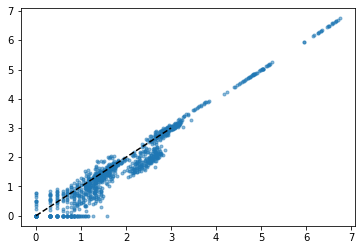

In [705]:
plt.scatter(np.log10(obs.flatten()), np.log10(np.clip(exp.flatten(), 1, None)), alpha=0.5, marker='.')
plt.plot([0, 3], [0, 3], color='black', linestyle='--')


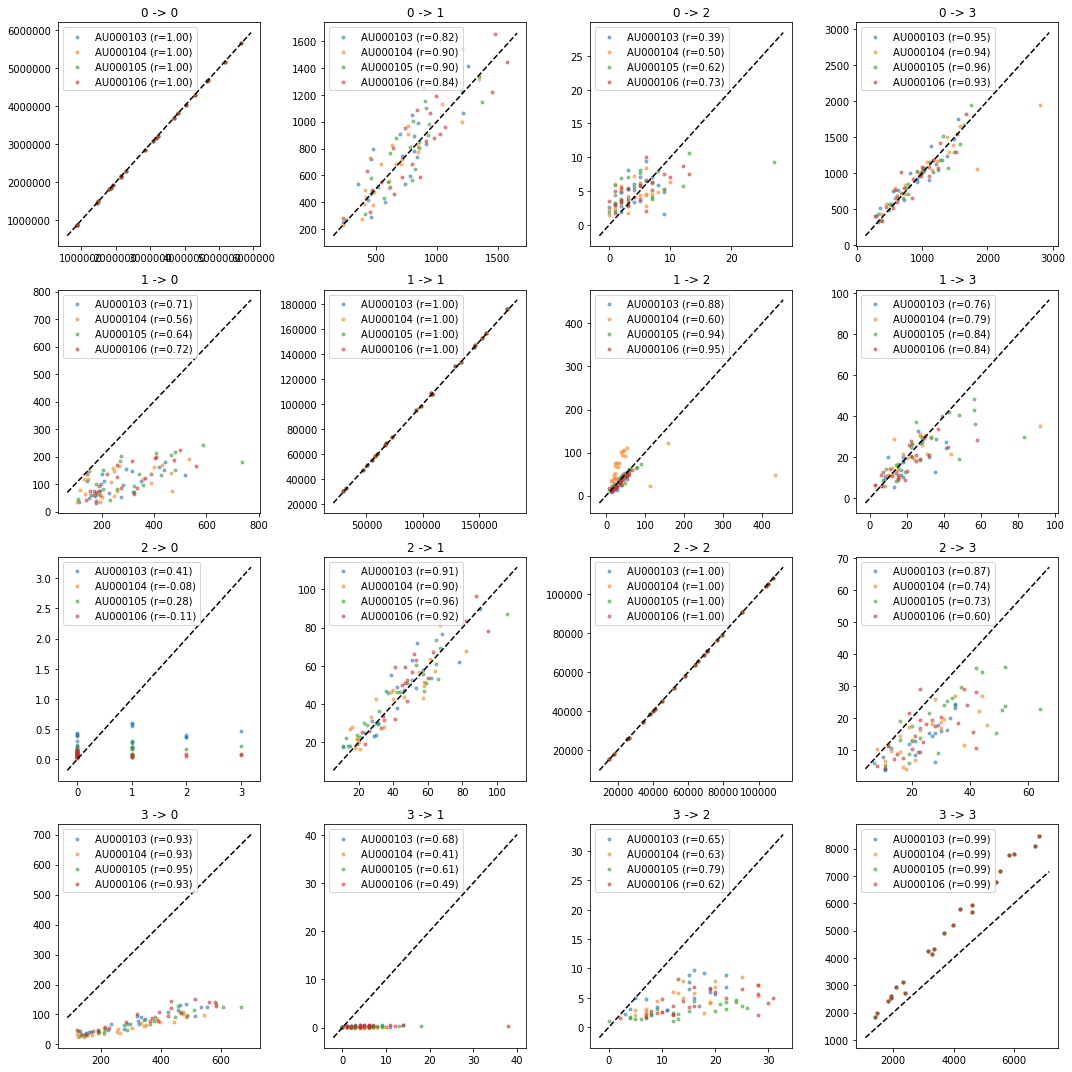

In [720]:
plt.figure(figsize=(15, 15))

for i, true_gen in enumerate([0, 1, 2, 3]):
    for j, obs_gen in enumerate([0, 1, 2, 3]):
        plt.subplot(4, 4, 4*i+j+1)
        plt.title('%s -> %s' % (true_gen, obs_gen))
        for k, ind in enumerate(ind_ids):
            index = tuple(obs_gen if k==l else true_gen for l in range(4))
            plt.scatter(obs[:, index[0], index[1], index[2], index[3]], 
                        exp[:, index[0], index[1], index[2], index[3]], 
                        label='%s (r=%0.2f)' % (ind, scipy.stats.spearmanr(obs[:, index[0], index[1], index[2], index[3]],
                                                                          exp[:, index[0], index[1], index[2], index[3]])[0]), alpha=0.5, marker='.')
        plt.legend()
        plt.plot(plt.xlim(), plt.xlim(), color='black', linestyle='--')
            
plt.tight_layout()
plt.show()
            

# Check LCL/WB

In [721]:
# Pull all LCL/WB pairs

with open('../parameter_estimation/ihart_ind_pass_params.json', 'r') as f:
    params = json.load(f)
    
lcls = [k for k in params.keys() if k.endswith('_LCL')]
wbs = [k[:-4] for k in lcls]
print(lcls, wbs)

['AU1043304_LCL', 'AU1308303_LCL', 'AU1860301_LCL', 'AU2410302_LCL', 'AU2911309_LCL', 'AU3051303_LCL', 'AU3053301_LCL', 'AU3154301_LCL', 'AU3646301_LCL', 'AU3702307_LCL', 'AU3713302_LCL', 'AU3761302_LCL', 'AU3839303_LCL', 'AU3846302_LCL', 'AU3913302_LCL', 'AU4235303_LCL'] ['AU1043304', 'AU1308303', 'AU1860301', 'AU2410302', 'AU2911309', 'AU3051303', 'AU3053301', 'AU3154301', 'AU3646301', 'AU3702307', 'AU3713302', 'AU3761302', 'AU3839303', 'AU3846302', 'AU3913302', 'AU4235303']


In [722]:
# pull error counts

# chrom, individual, wb_variant, lcl_variant
counts = np.zeros((len(chroms), len(lcls), 4, 4), dtype=int)

for i, chrom in enumerate(chroms):
    print(chrom, end=' ')
    
    with open('%s/chr.%s.famgen.counts.txt' % (data_dir, chrom), 'r') as f:
        for line in f:
            pieces = line.strip().split('\t')
            fk, inds = pieces[:2]
            inds = inds.split('.')

            in_lcl = list(set(inds) & set(lcls))
            if len(in_lcl) > 0:
                lcl_index = inds.index(in_lcl[0])
                wb_index = inds.index(in_lcl[0][:-4])
                for g, c in zip(product([0, 1, 2, 3], repeat=len(inds)), pieces[2:]):
                    counts[i, lcls.index(in_lcl[0]), g[wb_index], g[lcl_index]] += int(c)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 

In [723]:
# pull estimates of error counts
    
# chrom, individual, wb_variant, lcl_variant
exp = np.zeros((len(chroms), len(lcls), 4, 4))
obs = np.zeros((len(chroms), len(lcls), 4, 4))

gens = ['0/0', '0/1', '1/1', './.']


for l in range(len(lcls)):

    v = []
    X = []
    for wb_obs, lcl_obs in product([0, 1, 2, 3], repeat=2):
        v.append((wb_obs, lcl_obs))
        X.append([np.power(10.0, -params[wbs[l]]["-log10(P[obs=%s|true_gen=%s])" % (gens[wb_obs], true_gen)])*np.power(10.0, -params[lcls[l]]["-log10(P[obs=%s|true_gen=%s])" % (gens[lcl_obs], true_gen)]) for true_gen in ['0/0', '0/1', '1/1', '-/0', '-/1', '-/-']])
    X = np.array(X)

    for k, chrom in enumerate(chroms):
        try:
            e = []
            for wb_obs, lcl_obs in product([0, 1, 2, 3], repeat=2):
                e.append(counts[k, l, wb_obs, lcl_obs])     
            e = np.array(e)
            status, c, expected, observed = poisson_regression(X, e)

            for ((wb_variant, lcl_variant), ex, ob) in zip(v, expected, observed):
                exp[k, l, wb_variant, lcl_variant] = ex
                obs[k, l, wb_variant, lcl_variant] = ob
        except:
            pass

Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating...

optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inacc

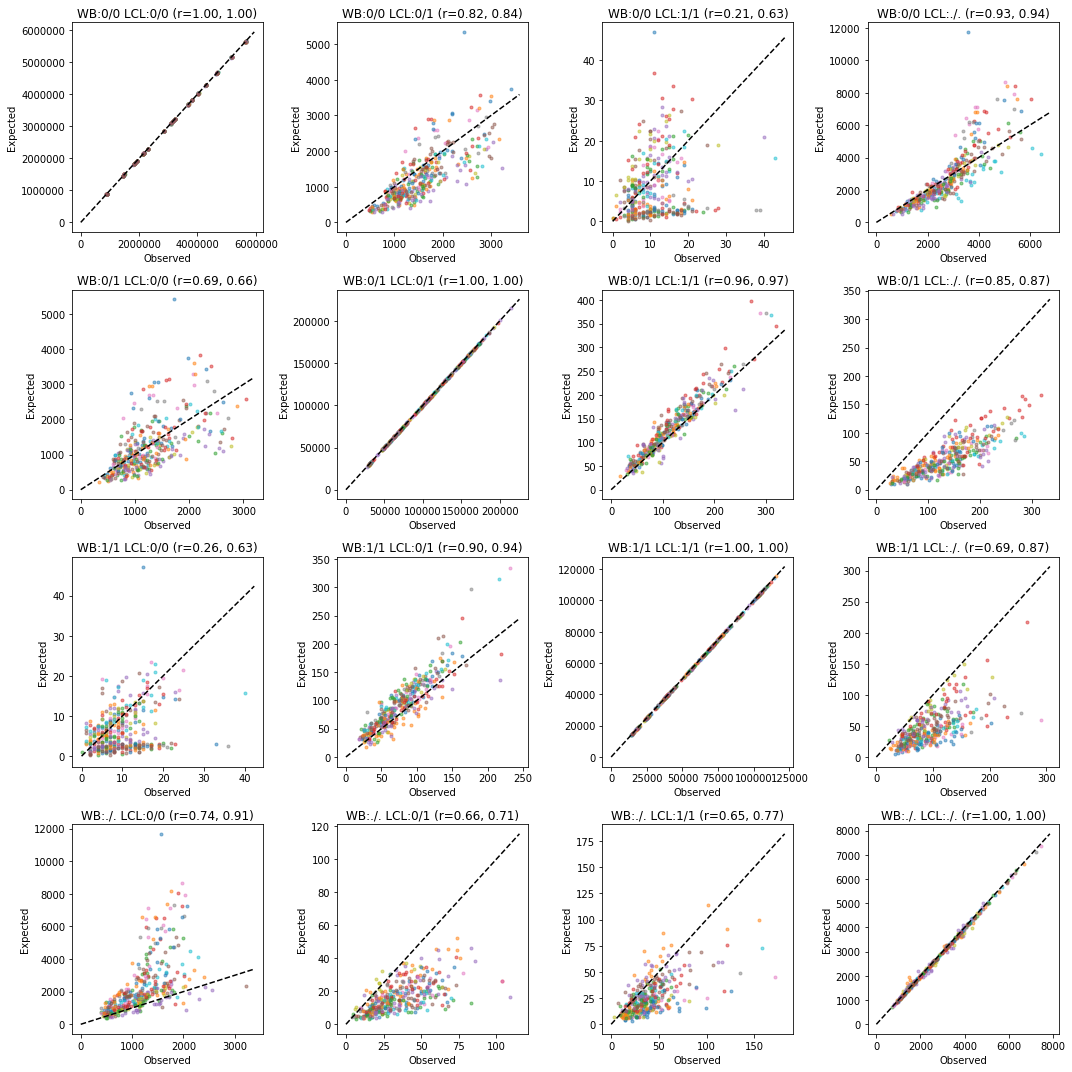

In [724]:
plt.figure(figsize=(15, 15))

for i, wb_obs in enumerate(['0/0', '0/1', '1/1', './.']):
    for j, lcl_obs in enumerate(['0/0', '0/1', '1/1', './.']):
        plt.subplot(4, 4, i*4 + j + 1)
        plt.title('WB:%s LCL:%s (r=%0.2f)' % (wb_obs, lcl_obs, scipy.stats.pearsonr(obs[:, :, j, i].flatten(), exp[:, :, j, i].flatten())[0]))
        plt.xlabel('Observed')
        plt.ylabel('Expected')
        rs = []
        for k in range(len(lcls)):
            r = scipy.stats.spearmanr(obs[:, k, j, i], exp[:, k, j, i])[0]
            rs.append(r)
            plt.scatter(obs[:, k, j, i], exp[:, k, j, i], alpha=0.5, marker='.', label='%s (r=%0.2f)' % (ind, r))
        plt.plot([0, plt.xlim()[1]], [0, plt.xlim()[1]], color='black', linestyle='--')
        #plt.legend()
        plt.title('WB:%s LCL:%s (r=%0.2f, %0.2f)' % (wb_obs, lcl_obs, scipy.stats.spearmanr(obs[:, :, j, i].flatten(), exp[:, :, j, i].flatten())[0], np.median(rs)))
    
plt.tight_layout()
plt.show()

# Check Twins

In [725]:
# Pull all twin pairs
has_sequence = set()
with open('%s/chr.%s.famgen.counts.txt' % (data_dir, chrom), 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        fk, inds = pieces[:2]
        inds = inds.split('.')
        has_sequence.update(inds[2:])

family_to_twins = defaultdict(list)
with open('../data/170925.iHART.db.csv', 'r') as f:
    for line in f:
        pieces = line.strip().split(',')
        if 'MZ' in pieces[11] and pieces[12] == '2' and pieces[2] in has_sequence and 'LCL' not in pieces[2]:
            #print(pieces[2], pieces[3], pieces[6], pieces[7], pieces[8])
            family_to_twins[pieces[3]].append(pieces[2])

lcls, wbs = [], []
twin_to_twin = dict()
for f, twins in family_to_twins.items():
    if len(twins) == 2:
        lcls.append(twins[0])
        wbs.append(twins[1])
        twin_to_twin[twins[0]] = twins[1]
        twin_to_twin[twins[1]] = twins[0]
print(len(lcls))


75


In [726]:
# pull error counts

# chrom, individual, wb_variant, lcl_variant
counts = np.zeros((len(chroms), len(lcls), 4, 4), dtype=int)

for i, chrom in enumerate(chroms):
    print(chrom, end=' ')
    
    with open('%s/chr.%s.famgen.counts.txt' % (data_dir, chrom), 'r') as f:
        for line in f:
            pieces = line.strip().split('\t')
            fk, inds = pieces[:2]
            inds = inds.split('.')

            in_lcl = list(set(inds) & set(lcls))
            if len(in_lcl) > 0:
                lcl_index = inds.index(in_lcl[0])
                wb_index = inds.index(twin_to_twin[in_lcl[0]])
                for g, c in zip(product([0, 1, 2, 3], repeat=len(inds)), pieces[2:]):
                    counts[i, lcls.index(in_lcl[0]), g[wb_index], g[lcl_index]] += int(c)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 

In [727]:
# pull estimates of error counts
    
# chrom, individual, wb_variant, lcl_variant
exp = np.zeros((len(chroms), len(lcls), 4, 4))
obs = np.zeros((len(chroms), len(lcls), 4, 4))

gens = ['0/0', '0/1', '1/1', './.']


for l in range(len(lcls)):

    v = []
    X = []
    for wb_obs, lcl_obs in product([0, 1, 2, 3], repeat=2):
        v.append((wb_obs, lcl_obs))
        X.append([np.power(10.0, -params[wbs[l]]["-log10(P[obs=%s|true_gen=%s])" % (gens[wb_obs], true_gen)])*np.power(10.0, -params[lcls[l]]["-log10(P[obs=%s|true_gen=%s])" % (gens[lcl_obs], true_gen)]) for true_gen in ['0/0', '0/1', '1/1', '-/0', '-/1', '-/-']])
    X = np.array(X)

    for k, chrom in enumerate(chroms):
        try:
            e = []
            for wb_obs, lcl_obs in product([0, 1, 2, 3], repeat=2):
                e.append(counts[k, l, wb_obs, lcl_obs])     
            e = np.array(e)
            status, c, expected, observed = poisson_regression(X, e)

            for ((wb_variant, lcl_variant), ex, ob) in zip(v, expected, observed):
                exp[k, l, wb_variant, lcl_variant] = ex
                obs[k, l, wb_variant, lcl_variant] = ob
        except:
            pass

Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating...

optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inacc

optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inacc

optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inacc

optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal
Estimating... (16, 6) (16,)
optimal_inaccurate
Estim

optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inacc

optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (1

optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inacc

optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inacc

optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate
Estimating... (16, 6) (16,)
optimal_inaccurate


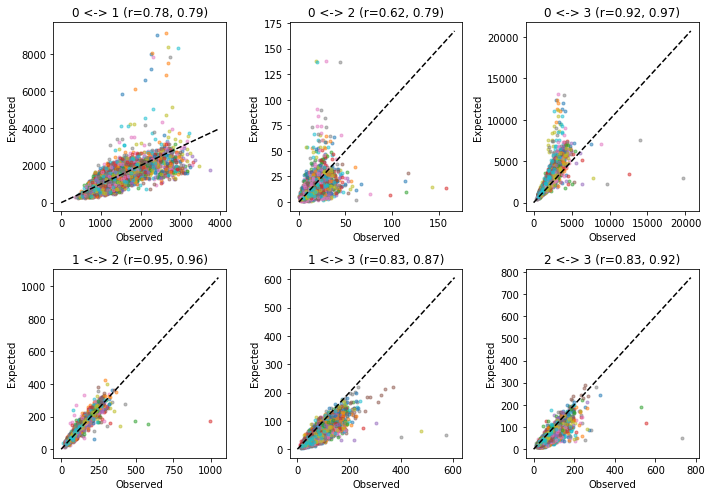

In [728]:
plt.figure(figsize=(10, 7))

for i, (wb_obs, lcl_obs) in enumerate([(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]):
    plt.subplot(2, 3, i+1)
    plt.xlabel('Observed')
    plt.ylabel('Expected')
    rs = []
    all_obs_values, all_exp_values = [], []
    for k in range(len(lcls)):
        r = scipy.stats.spearmanr(obs[:, k, wb_obs, lcl_obs], exp[:, k, wb_obs, lcl_obs])[0]
        rs.append(r)
        plt.scatter(obs[:, k, wb_obs, lcl_obs], exp[:, k, wb_obs, lcl_obs], alpha=0.5, marker='.', label='%s (r=%0.2f)' % (ind, r))
        all_obs_values.append(obs[:, k, wb_obs, lcl_obs].flatten())
        all_exp_values.append(exp[:, k, wb_obs, lcl_obs].flatten())
        
        r = scipy.stats.spearmanr(obs[:, k, lcl_obs, wb_obs], exp[:, k, lcl_obs, wb_obs])[0]
        rs.append(r)
        plt.scatter(obs[:, k, lcl_obs, wb_obs], exp[:, k, lcl_obs, wb_obs], alpha=0.5, marker='.', label='%s (r=%0.2f)' % (ind, r))
        all_obs_values.append(obs[:, k, lcl_obs, wb_obs].flatten())
        all_exp_values.append(exp[:, k, lcl_obs, wb_obs].flatten())
    plt.plot([0, plt.xlim()[1]], [0, plt.xlim()[1]], color='black', linestyle='--')
    #plt.legend()
    all_obs_values = np.hstack((all_obs_values))
    all_exp_values = np.hstack((all_exp_values))
    plt.title('%d <-> %d (r=%0.2f, %0.2f)' % (wb_obs, lcl_obs, scipy.stats.spearmanr(all_obs_values, all_exp_values)[0], np.median(rs)))
    #plt.xscale('log')
    #plt.yscale('log')
plt.tight_layout()
plt.show()